# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.2.1


# Set config


In [3]:
llm_config = LLMConfig(
    vocab_size=2_000,
    context_size=128,
    dim_emb=256,
    num_layers=4,
    num_heads=8,
    emb_dropout=0.0,
    ffd_dim_hidden=4 * 256,
    ffd_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=get_device(),
    batch_size=64,
    learning_rate=3e-4,
    weight_decay=1e-5,
    max_steps=4_000,
    log_frequency=1,
)

# Prepare tokenizer and dataset


In [4]:
input_file = "../data/shakespeare/tinyshakespeare.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

In [5]:
sentence = (
    "The role of the tokenizer is to build a mapping between a sentences represented as a string and token indices."
)
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁', 'ro', 'le', '▁of', '▁the', '▁to', 'k', 'en', 'ize', 'r', '▁is', '▁to', '▁bu', 'il', 'd', '▁a', '▁m', 'app', 'ing', '▁between', '▁a', '▁sentence', 's', '▁re', 'p', 're', 's', 'ent', 'ed', '▁as', '▁a', '▁str', 'ing', '▁and', '▁to', 'k', 'en', '▁in', 'd', 'ice', 's', '.']


In [6]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

X, y = ds_train.get_batch(batch_size=1)

print(X.shape, y.shape)

torch.Size([1, 128]) torch.Size([1, 128])


# Define model


In [7]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_hidden_dim=llm_config.ffd_dim_hidden,
    ffd_bias=llm_config.ffd_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

# print(model)

total params: 12,058,832
model size: 46.188MB


# Train model


In [8]:
loss_history = train(
    model,
    ds_train,
    train_config.device,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on mps.


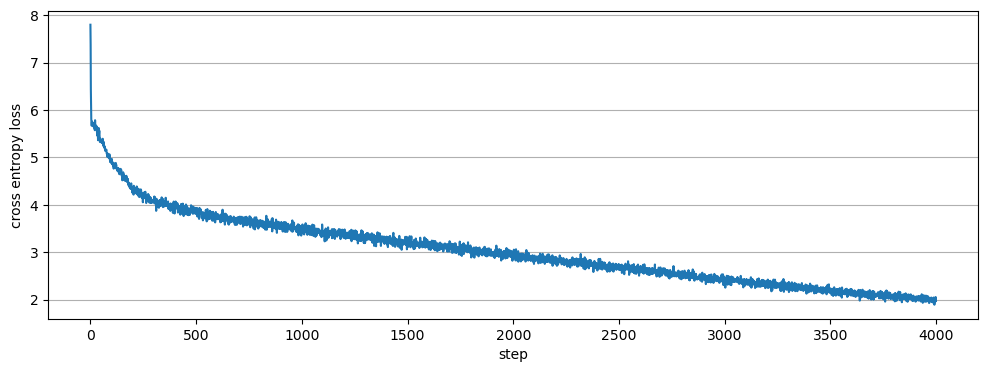

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

# Play around


In [23]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32)
prompt[..., 0] = tokenizer.bos_id
prompt = prompt.to(train_config.device)

out = model.generate(prompt, max_seq_len=128)
tokenizer.decode(out)

"; Vice doed thripsay: our heart nor house. Nay, what, be! Who? Come, come, the friar; Hath I climily to thy fairestiness. O God's king, at Saint Georges put How now, then answer'd what John now from Bence? KING RICHARD II: 'ALOPSice strong, ELIen light thy fears. Clown: No more true word, you have lost the hand; and,"

In [19]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "My King, I am at your service.",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=128)
tokenizer.decode(out)

"My King, I am at your service. JULIET: It were, I not. Now, Has no pity D without as under disrcherage'd of all: But thou goside thou not? Messenger: I wouldst know the princess whose loss: Come, burt Signior Baptistas! Lord Layow her son, marry an amit, Procure me supportions of Hible as me and round whether 'twixt pribute till then back"